# K-Means

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from itertools import combinations, izip
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set_style(style='white')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

## Load Iris Dataset

In [2]:
iris = load_iris()

In [3]:
X = scale(iris.data)
y = iris.target
X.shape

(150, 4)

## K-means Plotting Function

In [4]:
def plot_decision_boundary(model, X, y):
    # Takes in a 2D feature space for X
    
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .05     # point in the mesh [x_min, m_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = model.fit_predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    #plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Pastel1,
               aspect='auto', origin='lower')

    plt.scatter(X[:, 0], X[:, 1],
                c = y,
                cmap=plt.cm.Set1, s = 30)
    
    # Plot the centroids as a white X
    centroids = model.cluster_centers_
    
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='black', zorder=10)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

## Sklearn K-means

In [5]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(n_clusters=3, n_init=20)

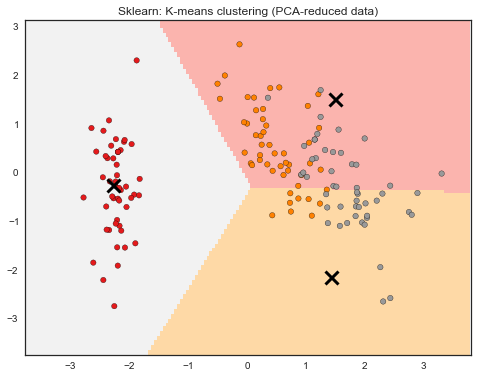

In [6]:
plot_decision_boundary(kmeans, reduced_data, y)
plt.title('Sklearn: K-means clustering (PCA-reduced data)')
plt.show()

## My Implementation of K-means Clustering

In [7]:
from KMeans import MyKMeans

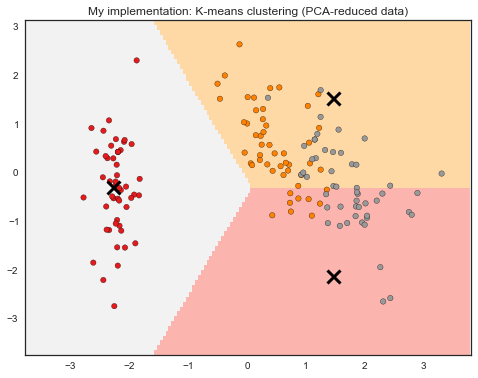

In [8]:
# This implemenation performs the clustering 10 times and pick the best 
# convergent model based on a clustering dispersion
Mykm = MyKMeans(n_clusters = 3,
                max_iterations = 40,
                n_init=10)

plot_decision_boundary(Mykm, reduced_data, y)
plt.title('My implementation: K-means clustering (PCA-reduced data)')
plt.show()

My implementation performs almost identical to the sklearn model.

## Plot Decision Boundary for Different Number of Clusters

In [9]:
def plot_k_clusters(X):
    plt.figure(figsize=(15, 30))
    for i, k in  enumerate([2, 3, 4, 5]):
        plt.subplot(4, 2, i+1)
        plt.title('K-means clustering (k = {})'.format(k))

        Mykm = MyKMeans(n_clusters = k,
                        max_iterations = 40,
                        n_init = 20)

        plot_decision_boundary(Mykm, X, y)
    plt.show()

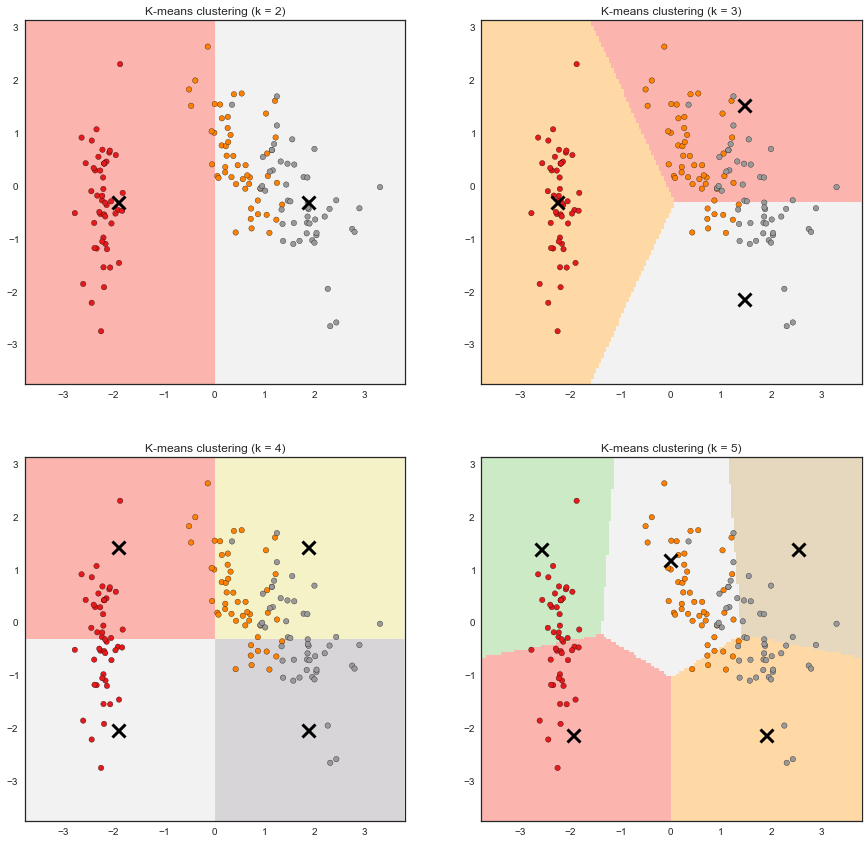

In [10]:
plot_k_clusters(reduced_data)

Visually it looks like 2 or 3 clusters do the best at segmenting the data.
We need to keep in my that this is not the original data. PCA was performed on the data and only the top 2 principle
components are plotted.

## Elbow Plot

In [11]:
def dispersion_k_clusters(X, max_clusters):    
    k_dispersion = []
    for k in  range(1, max_clusters+1):
        Mykm = MyKMeans(n_clusters = k,
                        max_iterations = 40,
                        n_init = 30)
        Mykm.fit_predict(X)
        k_dispersion.append(Mykm.dispersion)
    return k_dispersion

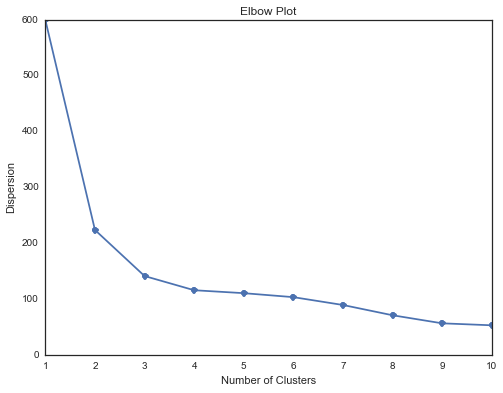

In [34]:
k_dispersion = dispersion_k_clusters(X, max_clusters = 10)

plt.plot(range(1, len(k_dispersion)+1), k_dispersion, marker = 'o')
plt.xlabel("Number of Clusters")
plt.ylabel("Dispersion")
plt.title("Elbow Plot");

It is not completely clear from the elbow plot what is the optimal number of clusters. The curve start to taper at around 3 clusters, but it's not obivous. A Better method is to look at the gap statistic.

## Generate Noise Data

In [13]:
def generate_noise(X):
    min_max = zip(np.min(X, axis = 0), np.max(X,axis = 0))
    return np.array(map(lambda t:
                        np.random.uniform(t[0], t[1], size = X.shape[0]),
                        min_max)).T

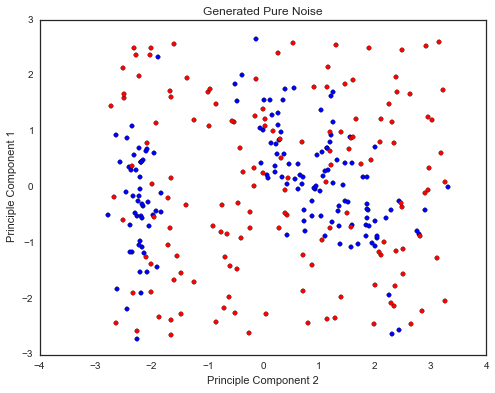

In [14]:
X_noise = generate_noise(reduced_data)
plt.scatter(reduced_data[:,0],reduced_data[:,1])
plt.scatter(X_noise[:,0],X_noise[:,1], c = 'r')
plt.title("Generated Pure Noise")
plt.ylabel("Principle Component 1")
plt.xlabel("Principle Component 2");

## Gap Statistic

In [15]:
def gap_statistic(X, max_clusters):
    X_noise = generate_noise(X)
    
    elbow_noise_data = np.array(dispersion_k_clusters(X_noise, max_clusters = max_clusters))
    # repeat 10 times
    elbow_noise_list = np.array([np.log(elbow_noise_data) for _ in range(10)])
    elbow_noise = np.mean(elbow_noise_list, axis=0)
    elbow_noise_std = np.std(elbow_noise_list, axis=0)

    sk = elbow_noise_std * np.sqrt(1+1./10)
    
    log_k_dispersion = np.log(np.array(dispersion_k_clusters(X, max_clusters = max_clusters)))
    
    return log_k_dispersion, elbow_noise, elbow_noise_std, sk

In [32]:
log_k_dispersion, elbow_noise, sd, sk = gap_statistic(X, max_clusters = 10)

gap = elbow_noise - k_dispersion

bar_gap = gap[:-1] - (gap - sk)[1:]

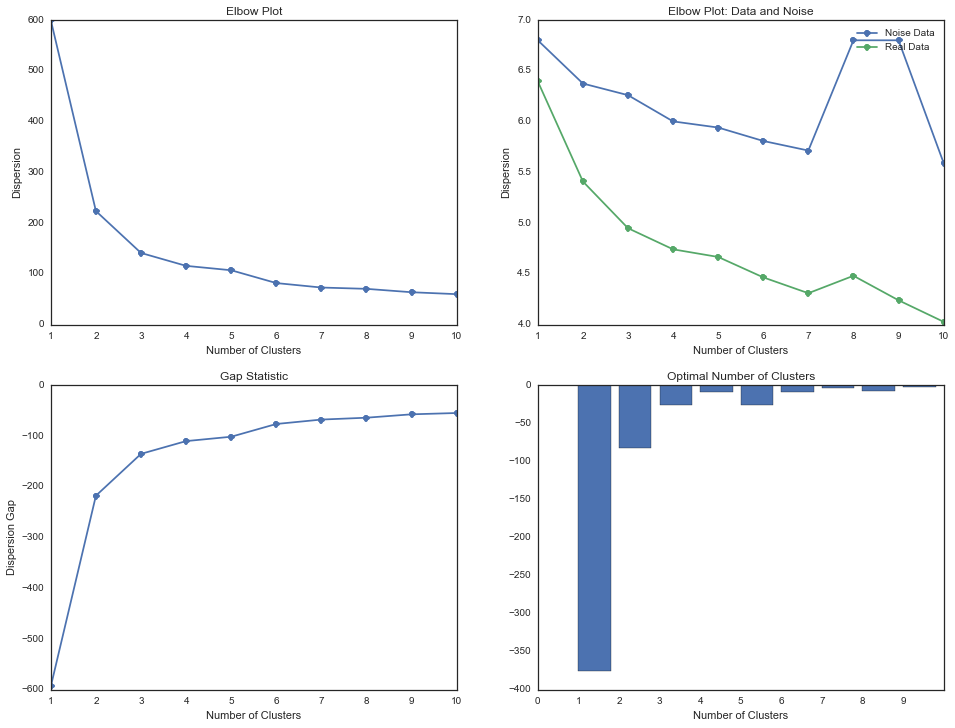

In [33]:
plt.figure(figsize=(16, 12))

#### 1.Elbow Plot
plt.subplot(2,2, 1)
plt.plot(range(1, len(k_dispersion)+1), k_dispersion, marker = 'o')
plt.xlabel("Number of Clusters")
plt.ylabel("Dispersion")
plt.title("Elbow Plot")

#### 2.Elbow Plot: Data and Noise
plt.subplot(2,2, 2)
plt.plot(range(1, len(elbow_noise)+1), elbow_noise, marker = 'o')
plt.plot(range(1, len(log_k_dispersion)+1), log_k_dispersion, marker = 'o')

plt.errorbar(range(1,11), elbow_noise, yerr=sd, linestyle="None")

plt.xlabel("Number of Clusters")
plt.ylabel("Dispersion")
plt.title("Elbow Plot: Data and Noise")
plt.legend(["Noise Data", "Real Data"])

#### 3.Gap Statistic
plt.subplot(2,2, 3)
plt.plot(range(1, len(gap)+1), gap, marker = 'o')
plt.xlabel("Number of Clusters")
plt.ylabel("Dispersion Gap")
plt.title("Gap Statistic")

#### 4.Bar Gap
plt.subplot(2,2, 4)
plt.bar(range(1,10),bar_gap)
plt.xlabel("Number of Clusters")
plt.title("Optimal Number of Clusters")
plt.xticks(range(10), label=range(10));

## Silhouette Analysis

('For n_clusters =', 2, 'The average silhouette_score is :', 0.58018446325739603)


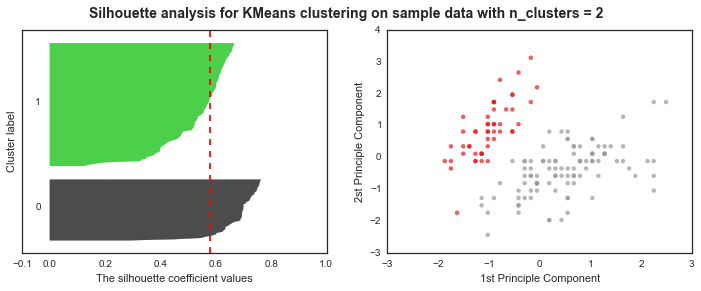

('For n_clusters =', 3, 'The average silhouette_score is :', 0.46089598326605125)


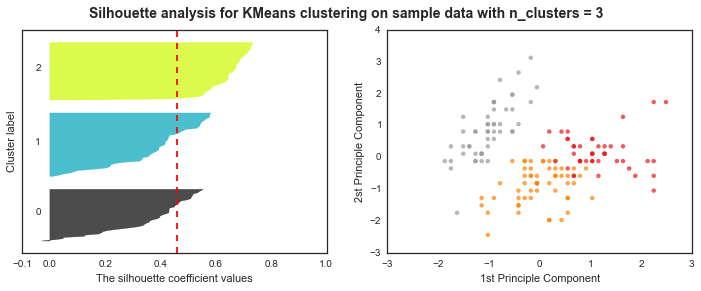

('For n_clusters =', 4, 'The average silhouette_score is :', 0.41205784435671361)


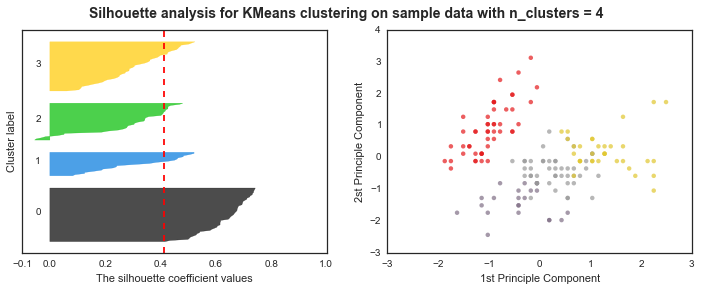

('For n_clusters =', 5, 'The average silhouette_score is :', 0.3742873364830232)


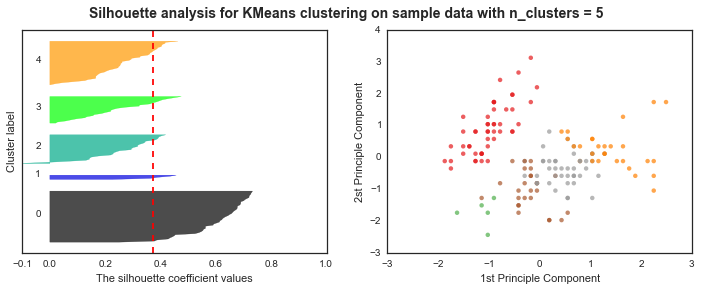

In [18]:
# source: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    clusterer = MyKMeans(n_clusters = n_clusters,
                    max_iterations = 40,
                    n_init = 30)
    cluster_labels = clusterer.fit_predict(reduced_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        #color = cm.Set1
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1],
                marker='.',
                s=80,
                lw=0,
                alpha=0.7,
                c=cluster_labels,
                cmap=plt.cm.Set1)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
#     ax2.scatter(centers[:, 0], centers[:, 1],
#                 marker='x', c="black", alpha=1, linewidths=3, s=100)

    ax2.set_xlabel("1st Principle Component")
    ax2.set_ylabel("2st Principle Component")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

The silhouette analysis shows that 2 and 3 clusters are the most likely for this dataset.

## 2-D Plot of Each Pair of Features

In [19]:
def plot_all_features(X, true_labels = False):
    plot_combinations = np.array(list(combinations(range(X.shape[1]), 2)))
    plt.figure(figsize=(10, 15))
    for i, f in  enumerate(plot_combinations):
        plt.subplot(4, 2, i+1)
        plt.title('K-means clustering: features {}'.format(f))

        Mykm = MyKMeans(n_clusters = 3,
                        max_iterations = 40,
                        n_init = 20)
        if true_labels:
            np.random.seed(0)
            plot_decision_boundary(Mykm, X[:, f], y)
        
        else:
            np.random.seed(0)
            clusters = Mykm.fit_predict(X)
            plt.scatter(X[:, f[0]], X[:, f[1]],
                        marker='.',
                        s=80,
                        lw=0,
                        alpha=0.7,
                        c= clusters,
                        cmap=plt.cm.Set1)
        
    plt.show()

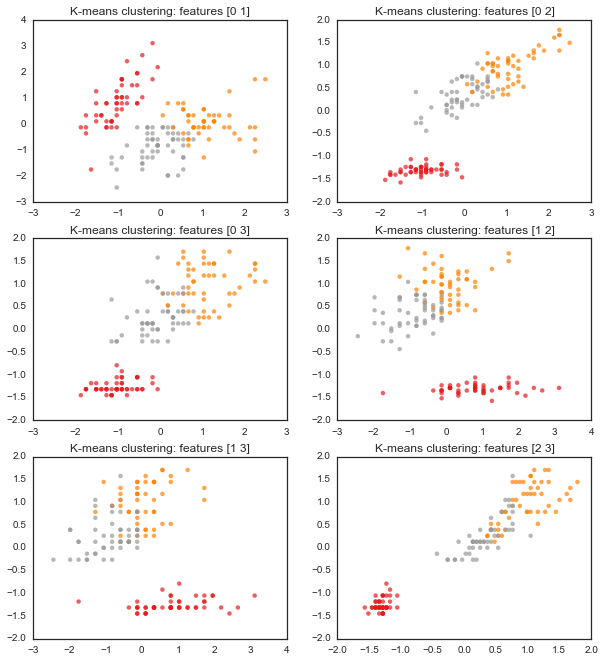

In [20]:
plot_all_features(X)

## Plot with True Cluster Labels

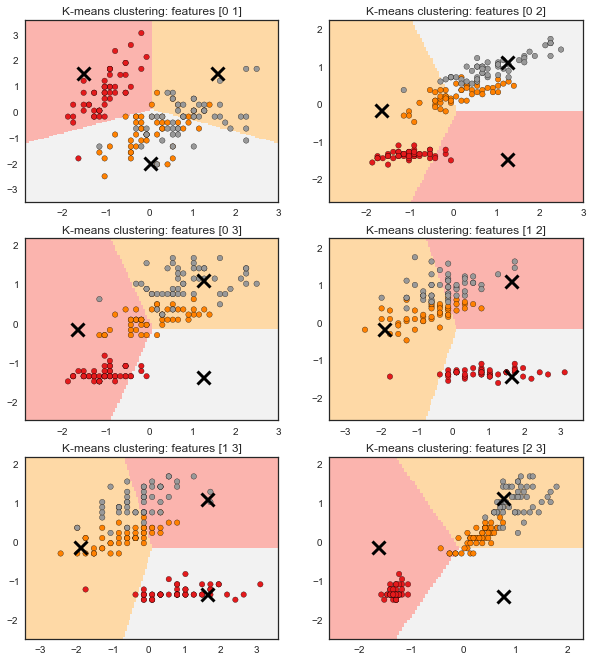

In [21]:
plot_all_features(X, true_labels=True)

## 3D Plots

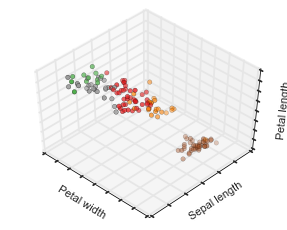

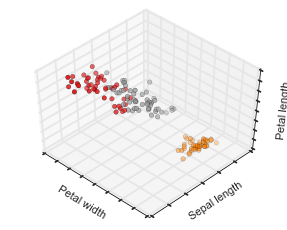

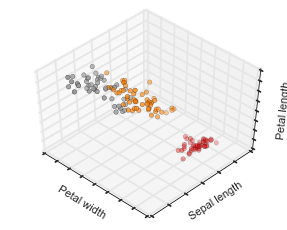

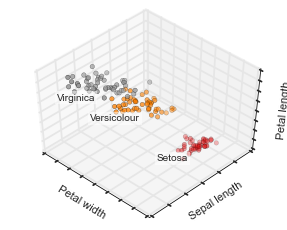

In [31]:
# source: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html

estimators = {'k_means_iris_3': MyKMeans(n_clusters = 3, n_init = 20),
              'k_means_iris_8': MyKMeans(n_clusters = 5, n_init = 20),
              'k_means_iris_bad_init': MyKMeans(n_clusters = 3, n_init = 1)}

fignum = 1
i = 1
for name, est in estimators.items():
    #fig = plt.subplot(2, 2, i)
    fig = plt.figure(fignum, figsize=(4, 3))

    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    labels = est.fit_predict(X)

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels, cmap=plt.cm.Set1)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    fignum = fignum + 1
    i += 1
# Plot the ground truth
fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)



for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results

ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
plt.show()
